# Part 1. Neuron Network Model


In [1]:
!pip install brian2

from brian2 import *
from brian2 import start_scope
import brian2 as b2

import numpy as np
from numpy import random
import matplotlib.pyplot as plt

from scipy.signal import find_peaks, butter, filtfilt
import matplotlib.animation as animation

import collections


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.7 MB/s eta 0:00:00


# 1. a) Model

In [30]:
start_scope()
import pandas as pd0
from brian2 import *
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

#**Parameters**
#General setup parameters
p_syn = 0.5 #probability of synapse formation between two neurons
N =30 #total number of neurons in the network
N_exc = int(0.8 * N)
N_inh = int(0.2 * N)
W0 = 10 #scaling factor

#Parameters for tuning
g_syn_max_exc_value = 0.01 # Masquelier Deco 2013 adaptation related parameters, maximum synaptic conductance
g_syn_max_inh_value = 0.1 # Valero 2022 Inhibitory conductance controls place field dynamics in the hippocampus
#Imid_value = 0.3

g_syn_max_exc = g_syn_max_exc_value*uS
g_syn_max_inh = g_syn_max_inh_value*uS

#Neuronal parameters
C_mem = 200*pF  # from https://doi.org/10.1063/1.5087129 membranae capacitnce
V_L = -70*mV    # '' leak potential (resting potential)
g_mem = 12*nS   # ''membrane conductance (leak conductance)
D_T = 2*mV      # ''slope factor for exponential integrate and fire model
V_T = -50*mV    # ''threshold potential for eif model

#Synaptic parameters
V_syn_exc = 0*mV    # ''Excitatory synaptic reversal potential
V_syn_inh = -75 * mV  # Inhibitory reversal potential
tau_r = 5*ms    # from https://neuronaldynamics.epfl.ch/online/Ch3.S1.html, NMDA synapse time constant of synaptic rise
tau_d = 50*ms   # '' time constant of synaptic decay
g_A = 4*nS # Brette&Gerstner adaptation related parameter
tau_A = 500*ms # why not 300 ? Brette&Gerstner 500*ms adaptation related parameter
b = 0.02*nA # Brette&Gerstner adaptationr elated paraeter

#Noise parameters
tau_noise = 10 * ms  # correlation time (longer = smoother noise)
sigma_noise = 0.001 * nA  # noise amplitude

#simulation parameters
runtime = 10*second #simulation duration
set_dt = 0.01*ms #timestep of simulation

#Electrode grid parameters
gridsize = 1 #electrodes arranged on a grid of a size 1mm
gridunit = mm
maxsyndist = sqrt(2)*gridsize #synaptic connection distance
sigma = 2*siemens/meter   # conductivity of saline medium
N_elec = 12 #number if electodes for measuring LFP
border = 0.1
sqrtN = 4

Vt = V_T+10*mV    # numerical spike threshold, formally inf in EIF neurons
Vr = -75*mV     # needs adjustment. See Badel et al for EIF neuron tuning to experiments?
refPeriod = 0*ms
dt_inf = C_mem/g_mem*exp((V_T-Vt)/D_T)

#External input characteristics
Imid = 0.3 *nA

#**Neuronal grid characteristics & virtual electrodes**
coor1D = np.atleast_2d(np.linspace(border - gridsize/2, gridsize/2 - border, sqrtN))  # Center around 0
Xe = np.array([(np.transpose(coor1D) * np.ones([1, sqrtN])).flatten(), (np.ones([sqrtN, 1]) * coor1D).flatten()])
Xe = np.delete(Xe.T, [0, 3, 12, 15], axis=0)


# **Model Equations**
#Neuron model equations (both inhibitory and excitatory)
eqs_EIF = '''
dV/dt = 1/C_mem * (I_leak + I_exp - (I_syn_exc + I_syn_inh) + I_noise - A) : volt (unless refractory)
dA/dt = 1/tau_A*(g_A*(V-V_L)-A) : ampere
dI_noise/dt = -(I_noise-Imid)/tau_noise + sigma_noise * sqrt(2/tau_noise) * xi : ampere
Imid :ampere

s_tot_exc:1 #summed contribution of excitatory synaptic iputs from all presynaptic neurons
s_tot_inh:1 #summed contribution of inhibitory synaptic inputs from all presynaptic neurons

I_syn_exc = g_syn_max_exc * s_tot_exc * (V - V_syn_exc) : ampere #Excitatory synaptic current
I_syn_inh = g_syn_max_inh * s_tot_inh * (V - V_syn_inh) : ampere #Inhibitory synaptic current
I_leak = -g_mem*(V-V_L) : ampere #nA
I_exp = g_mem*D_T*exp((V-V_T)/D_T) : ampere #nA
I_sum = I_leak + I_exp - (I_syn_exc + I_syn_inh) + I_noise : ampere


x1 : 1
x2 : 1
'''

#Synapse model equations
eqs_synapse_exc = '''
ds_syn_exc/dt = x_exc : 1 (clock-driven)
dx_exc/dt = 1/(tau_r*tau_d) *( -(tau_r+tau_d)*x_exc - s_syn_exc ) : Hz (clock-driven)
s_tot_exc_post = w/N_exc*s_syn_exc :1 (summed)
w : 1 #dimensionless
'''

eqs_synapse_inh = '''
ds_syn_inh/dt = x_inh :1 (clock-driven) #since unit of the derivative is 1/s, unit of s_syn_exc is dimensionless
dx_inh/dt = 1/(tau_r*tau_d) *( -(tau_r+tau_d)*x_inh - s_syn_inh ) : Hz (clock-driven) #order of magnitude 10**3
s_tot_inh_post = w/N_exc*s_syn_inh :1 (summed)
w : 1 #dimensionless
'''

eqs_reset = '''
V=Vr
A+=b
'''

eqs_onpre_exc = '''
x_exc += 1*Hz
'''

eqs_onpre_inh = '''
x_inh += 1*Hz
'''


# **Defining neural populations in brian and their positions**
#Excitatory Neuron Population
Pop_exc = NeuronGroup(N_exc, eqs_EIF, threshold='V>Vt', reset=eqs_reset, refractory=refPeriod, method='euler') #population of excitatory neurons
Pop_exc.V = np.random.uniform(-60, -50, N_exc) * mV
Pop_exc.A = 0.1*nA
#Pop_exc.I = np.random.uniform(Imid-Iwid,Imid+Iwid,N_exc)*nA  #initializes intriinsic current according to uniform distribution
#alternatively: #Pop_exc.I = random.normal(Imid,Iwid,N_exc)*nA #initializes input current to excitatory neurons according to normal distribution
Pop_exc.I_noise = 0 * nA #noise initialized to zero
Pop_exc.Imid = Imid

#Inhibitory Neuron Population
Pop_inh = NeuronGroup(N_inh, eqs_EIF, threshold='V>Vt', reset=eqs_reset, refractory=refPeriod, method='euler') #population of inhibitory neurons
Pop_inh.V = np.random.uniform(-60, -50, N_inh) * mV
Pop_inh.A = 0.1*nA
#Pop_inh.I = np.random.uniform(Imid - Iwid, Imid + Iwid, N_inh) * nA
Pop_inh.I_noise = 0 * nA #noise initialized to zero
Pop_inh.Imid =  Imid

# **Defining positions of neurons on the circular grid**
R = gridsize  # radius of the circular grid

# generate random polar coordinates for excitatory neurons
r_exc = R * np.sqrt(np.random.rand(N_exc))
theta_exc = np.random.rand(N_exc) * 2 * np.pi

# convert polar to Cartesian coordinates
X_position_exc = np.column_stack((r_exc * np.cos(theta_exc), r_exc * np.sin(theta_exc)))

# generate random polar coordinates for inhibitory neurons
r_inh = R * np.sqrt(np.random.rand(N_inh))
theta_inh = np.random.rand(N_inh) * 2 * np.pi

# convert polar to Cartesian coordinates
X_position_inh = np.column_stack((r_inh * np.cos(theta_inh), r_inh * np.sin(theta_inh)))

# Assign coordinates to NeuronGroups
Pop_exc.x1, Pop_exc.x2 = X_position_exc[:, 0], X_position_exc[:, 1]
Pop_inh.x1, Pop_inh.x2 = X_position_inh[:, 0], X_position_inh[:, 1]


# **Defining Synapse Connections in brian**
# Excitatory to Excitatory
Syn_EE = Synapses(Pop_exc, Pop_exc, on_pre=eqs_onpre_exc, model=eqs_synapse_exc, method='rk4')
Syn_EE.connect(p='p_syn*(1-sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/(maxsyndist))')
if p_syn!=0:
    Syn_EE.w = W0/p_syn
Syn_EE.w *= 0.5  # Reduce excitation strength

# Excitatory to Inhibitory
Syn_EI = Synapses(Pop_exc, Pop_inh, on_pre=eqs_onpre_exc, model=eqs_synapse_exc, method='rk4')
Syn_EI.connect(p='p_syn*(1-sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/(maxsyndist))')
if p_syn!=0:
    Syn_EI.w = W0/p_syn
Syn_EI.w *= 0.5  # Reduce excitation to inhibitory neurons

# Inhibitory to Excitatory
Syn_IE = Synapses(Pop_inh, Pop_exc, on_pre=eqs_onpre_inh, model=eqs_synapse_inh, method='rk4')
Syn_IE.connect(p='p_syn*(1-sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/(maxsyndist))')
if p_syn!=0:
    Syn_IE.w = - W0/p_syn


# Inhibitory to Inhibitory
Syn_II = Synapses(Pop_inh, Pop_inh, on_pre=eqs_onpre_inh, model=eqs_synapse_inh, method='rk4')
Syn_II.connect(p='p_syn*(1-sqrt((x1_pre-x1_post)**2+(x2_pre-x2_post)**2)/(maxsyndist))')
if p_syn!=0:
    Syn_II.w = - W0/p_syn


# **Setting up monitors in brian**
SpikeMon_exc = SpikeMonitor(Pop_exc)  #monitors spiking activity of excitatory neuron popultion
SpikeMon_inh = SpikeMonitor(Pop_inh)  #monitors spiking activity of inhibitory neuron popultion
StateMon_exc = StateMonitor(Pop_exc, variables=['V','I_syn_exc','I_leak','I_exp','A', 'I_sum', 'Imid', 'I_syn_inh'], record=True, dt=1*ms)
StateMon_inh = StateMonitor(Pop_inh, variables=['V','I_syn_inh','I_leak','I_exp','A', 'I_sum', 'Imid','I_syn_exc'], record=True, dt=1*ms)


# **Counting synapses for both excitatory and inhibitory neurons**
pre_neurons_exc = Syn_EE.i  # Pre-synaptic indices for Excitatory → Excitatory
post_neurons_exc = Syn_EE.j  # Post-synaptic indices for Excitatory → Excitatory
pre_neurons_inh = Syn_IE.i + N_exc  # Pre-synaptic indices for Inhibitory → Excitatory (offset by N_exc)
post_neurons_inh = Syn_IE.j  # Post-synaptic indices for Inhibitory → Excitatory

# Combine all synapse indices
pre_neurons = np.concatenate((pre_neurons_exc, pre_neurons_inh))
post_neurons = np.concatenate((post_neurons_exc, post_neurons_inh))

# Count synapses
unique, counts = np.unique(pre_neurons, return_counts=True)
synapse_count_per_neuron = dict(zip(unique, counts))  # Map neuron to outgoing synapse count


# **Set up virtual electrodes**
# Equations
eqs_elec = '''
Imem_w_exc :ampere/meter
Imem_w_inh :ampere/meter
LFP = 1/(4*pi*sigma) * (Imem_w_exc + Imem_w_inh) : volt # Sum contributions for LFP
'''

eqs_record_exc = '''
dist : meter
Imem_w_exc_post = I_sum_pre/dist : ampere/meter (summed) # Update excitatory variable
'''

eqs_record_inh = '''
dist : meter
Imem_w_inh_post = I_sum_pre/dist : ampere/meter (summed) # Update inhibitory variable
'''


# ** Define population of electrodes in brian**
ELEC = NeuronGroup(N_elec, eqs_elec)  # Virtual electrodes
Syn_LFP_exc = Synapses(Pop_exc, ELEC, model=eqs_record_exc, method='exact')  # connect excitatory neurons to electrodes
Syn_LFP_inh = Synapses(Pop_inh, ELEC, model=eqs_record_inh, method='exact')  # connect inhibitory neurons to electrodes

# Connect electrodes to both populations
Syn_LFP_exc.connect()
Syn_LFP_inh.connect()


# **LFP calcualtion**
# Compute distances for LFP contributions
Syn_LFP_exc.dist = np.sqrt(np.sum((np.vstack([Xe for _ in range(N_exc)]) - np.repeat(X_position_exc, N_elec, axis=0))**2, axis=1)) * gridunit
Syn_LFP_inh.dist = np.sqrt(np.sum((np.vstack([Xe for _ in range(N_inh)]) - np.repeat(X_position_inh, N_elec, axis=0))**2, axis=1)) * gridunit

# Monitor LFP signals
ElecMon = StateMonitor(ELEC, variables='LFP', record=True, dt=1*ms)


# **Network and simulation**
# Add everything to the network
net = Network(collect())
net.add(SpikeMon_exc, SpikeMon_inh, StateMon_exc, StateMon_inh, ElecMon)

# Run simulation for first 2 seconds to get the transient
defaultclock.dt = set_dt
#transient_duration = 2 * second
#net.run(transient_duration)

# Store network state
#net.store(name='state_at_2s')
#print("Network state stored at 2 seconds.")


# **Continue simulation**
#net.run(runtime - transient_duration)
net.run(runtime)


WARNING    'Imid' is an internal variable of group 'neurongroup_3', but also exists in the run namespace with the value 300. * pamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'Imid' is an internal variable of group 'neurongroup_4', but also exists in the run namespace with the value 300. * pamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


# 1. b) Removed transient (new monitors after transient)

In [ ]:
SimulationResult = collections.namedtuple('SimulationResult', 'net, new_SpikeMon_exc, new_SpikeMon_inh, new_StateMon_exc, new_StateMon_inh, new_ElecMon')


def simulation_without_transient(N, p_syn, W0, g_syn_max_value):

  net.restore(name='state_at_2s')
  print("Network state restored to 2 seconds.")

  #check monitor
  #print(f" {new_SpikeMon_exc.num_spikes}")

  # Create additional monitors for simulations without the transient, but disable them for now
  new_SpikeMon_exc = SpikeMonitor(Pop_exc)  # only starts after transient
  new_SpikeMon_inh = SpikeMonitor(Pop_inh)
  new_StateMon_exc = StateMonitor(Pop_exc, variables=['V','I_syn_exc','I_syn_inh','I_leak','I_exp','A', 'I_sum', 'Imid'], record=True)

  new_StateMon_inh = StateMonitor(Pop_inh, variables=['V','I_syn_inh','I_syn_exc','I_leak','I_exp','A', 'I_sum', 'Imid'], record=True)
  new_ElecMon = StateMonitor(ELEC, variables='LFP', record=True) #for LFPs after the transient

  net.add(new_SpikeMon_exc, new_SpikeMon_inh, new_StateMon_exc, new_StateMon_inh, new_ElecMon)

  runtime_without_transient = 8*second
  net.run(runtime_without_transient)

  #check monitor
  print(f" {new_SpikeMon_exc.num_spikes}")

  return SimulationResult(net, new_SpikeMon_exc, new_SpikeMon_inh, new_StateMon_exc, new_StateMon_inh, new_ElecMon)

# Run simulation and get results
NM = simulation_without_transient(N, p_syn, W0, g_syn_max_exc_value )


# Part 2. Visualizing Unerlying Network Model Behavior

# 2. a) Connectivity in the Network

    0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29
0    0   0   0   0   1   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   1   0   0   0   0
1    0   1   0   0   0   0   0   0   1   0   0   1   0   0   0   0   0   0   0   0   0   1   0   0   0   0   1   0   1   0
2    0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   1   0   0   1   0   0   0   0   0   0   0   0   1   1   0
3    0   0   0   1   0   0   0   0   0   1   0   0   0   0   0   1   0   1   0   0   1   0   0   0   0   0   0   0   0   0
4    0   1   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   1   0   0
5    0   0   0   0   0   1   1   0   0   0   0   0   0   0   0   0   1   0   1   0   0   0   0   0   0   0   0   1   0   0
6    0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   1   0   0   0   0   0
7    0   0   1  

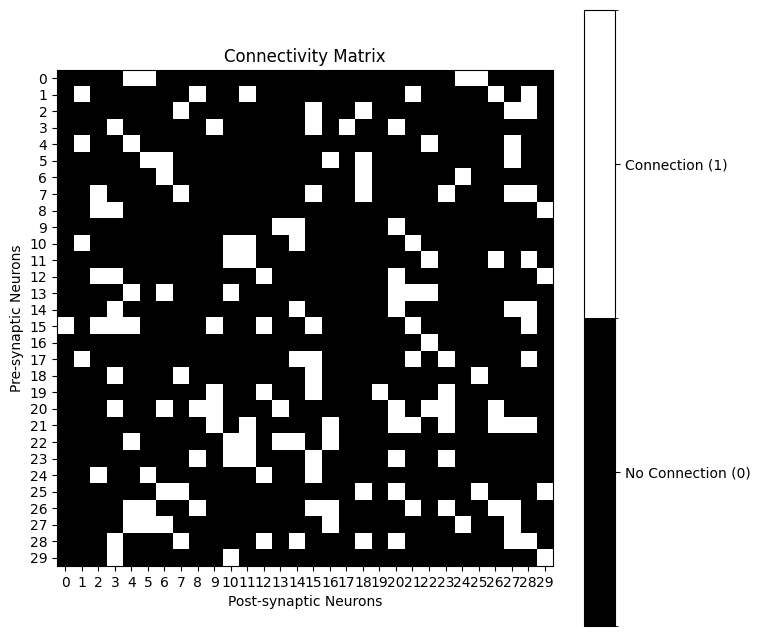

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

# total number of neurons (excitatory + inhibitory)
N_total = N_exc + N_inh

# initialize a connectivity matrix with zeros
# rows: pre-synaptic neurons; columns: post-synaptic neurons
connectivity = np.zeros((N_total, N_total), dtype=int)

# excitatory-to-excitatory (Syn_EE):
# pre: excitatory indices (0 to N_exc-1)
# post: excitatory indices (0 to N_exc-1)
connectivity[Syn_EE.i, Syn_EE.j] = 1

# excitatory-to-inhibitory (Syn_EI):
# pre: excitatory indices (0 to N_exc-1)
# post: inhibitory indices (local indices 0 to N_inh-1, so add offset N_exc)
connectivity[Syn_EI.i, Syn_EI.j + N_exc] = 1

# inhibitory-to-excitatory (Syn_IE):
# pre: inhibitory indices (local indices 0 to N_inh-1, so add offset N_exc)
# post: excitatory indices (0 to N_exc-1)
connectivity[Syn_IE.i + N_exc, Syn_IE.j] = 1

# inhibitory-to-inhibitory (Syn_II):
# pre: inhibitory indices (local indices, add offset N_exc)
# post: inhibitory indices (local indices, add offset N_exc)
connectivity[Syn_II.i + N_exc, Syn_II.j + N_exc] = 1


# **convert this numpy array to a pandas DataFrame for easier viewing**
# Set display options to show all columns in one row
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)  # adjust width as needed

conn_df = pd.DataFrame(connectivity)
print(conn_df)

# **Create connectivity matrix visual representation**
# create a discrete colormap: 0 -> black, 1 -> white.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# total number of neurons (excitatory + inhibitory)
N_total = connectivity.shape[0]

# create a discrete colormap: 0 -> black, 1 -> white.
cmap = mcolors.ListedColormap(['black', 'white'])
bounds = [-0.5, 0.5, 1.5]  # boundaries so that 0 maps to the first color and 1 to the second
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(8, 8))
img = plt.imshow(connectivity, cmap=cmap, norm=norm, interpolation='none')
plt.title("Connectivity Matrix")
plt.xlabel("Post-synaptic Neurons")
plt.ylabel("Pre-synaptic Neurons")

# Set the x and y ticks to discrete neuron numbers
plt.xticks(np.arange(N_total), np.arange(N_total))
plt.yticks(np.arange(N_total), np.arange(N_total))

# create a discrete colorbar with labels
cbar = plt.colorbar(img, ticks=[0, 1])
cbar.ax.set_yticklabels(['No Connection (0)', 'Connection (1)'])
plt.show()


Are all excitatory neurons receiving inhibitory connections?

In [21]:
#**Count number of inhibitory connections each excitatory neuron receives**

#count inhibitory inputs received by each excitatory neuron
inhibitory_targets = np.bincount(Syn_IE.j, minlength=N_exc) #Syn_IE is the group connecting inhibitory neurons to excitatory, Syn_IE.j contains postsynptic excitatory neuron indices

print("Number of inhibitory connections per excitatory neuron:", inhibitory_targets)

# find excitatory neurons that receive no inhibition
neurons_without_inhibition = np.where(inhibitory_targets == 0)[0]

if len(neurons_without_inhibition) > 0:
    print("⚠️: These excitatory neurons receive no inhibition:", neurons_without_inhibition)
else:
    print("✅ All excitatory neurons receive inhibitory connections.")


Number of inhibitory connections per excitatory neuron: [0 0 1 2 2 3 2 2 1 0 1 0 2 0 1 2 2 0 2 0 2 1 0 1]
⚠️: These excitatory neurons receive no inhibition: [ 0  1  9 11 13 17 19 22]


Inhibitory connections heatmap to see if inhibitory connections are well distributed:

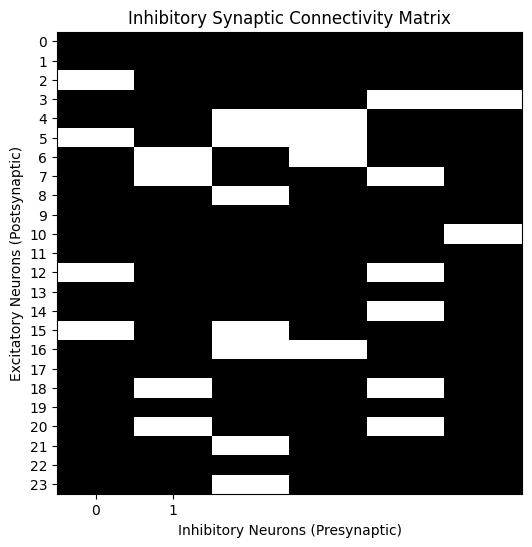

In [22]:
import matplotlib.pyplot as plt

# Create empty connectivity matrix
connectivity_matrix = np.zeros((N_exc, N_inh))

# Fill matrix: each row is an excitatory neuron, each column is an inhibitory neuron
for i, j in zip(Syn_IE.i, Syn_IE.j):  # i = inhibitory, j = excitatory
    connectivity_matrix[j, i] = 1  # Mark a connection

# Plot connectivity matrix
plt.figure(figsize=(6, 6))
plt.imshow(connectivity_matrix, cmap="gray", aspect="auto")

# Set axis labels
plt.xlabel("Inhibitory Neurons (Presynaptic)")
plt.ylabel("Excitatory Neurons (Postsynaptic)")
plt.title("Inhibitory Synaptic Connectivity Matrix")

# Set x-ticks to only mark `0` and `1`
plt.xticks([0, 1], ["0", "1"])  # Only label the two inhibitory neurons

# Ensure y-axis shows all excitatory neurons properly
plt.yticks(range(N_exc), [str(i) for i in range(N_exc)])

plt.show()

In [23]:
import numpy as np

# count inhibitory inputs received by each excitatory neuron
inhibitory_targets = np.bincount(Syn_IE.j, minlength=N_exc)
print(
    "Number of inhibitory connections per excitatory neuron:", inhibitory_targets
)

# count excitatory inputs received by each excitatory neuron
excitatory_targets_exc = np.bincount(Syn_EE.j, minlength=N_exc)
print(
    "Number of excitatory connections per excitatory neuron:",
    excitatory_targets_exc,
)

# count excitatory inputs received by each inhibitory neuron
excitatory_targets_inh = np.bincount(Syn_EI.j, minlength=N_inh)
print(
    "Number of excitatory connections per inhibitory neuron:",
    excitatory_targets_inh,
)

# count inhibitory inputs received by each inhibitory neuron
inhibitory_targets_inh = np.bincount(Syn_II.j, minlength=N_inh)
print(
    "Number of inhibitory connections per inhibitory neuron:",
    inhibitory_targets_inh,
)


# **For excitatory neurons**
# compute total inputs per excitatory neuron
total_inputs_exc = excitatory_targets_exc + inhibitory_targets

frac_inhibitory_exc = np.where(total_inputs_exc > 0, inhibitory_targets / total_inputs_exc, 0)
frac_excitatory_exc = np.where(total_inputs_exc > 0, excitatory_targets_exc / total_inputs_exc, 0)

# calculate the average fractions across the excitatory population
avg_frac_inhibitory_exc = np.mean(frac_inhibitory_exc)
avg_frac_excitatory_exc = np.mean(frac_excitatory_exc)

print("Average fraction of inhibitory inputs for excitatory neurons:", avg_frac_inhibitory_exc*100, "%")
print("Average fraction of excitatory inputs for excitatory neurons:", avg_frac_excitatory_exc*100, "%")


# **For inhibitory neurons **
total_inputs_inh = excitatory_targets_inh + inhibitory_targets_inh

frac_excitatory_inh = np.where(total_inputs_inh > 0, excitatory_targets_inh / total_inputs_inh, 0)
frac_inhibitory_inh = np.where(total_inputs_inh > 0, inhibitory_targets_inh / total_inputs_inh, 0)

# calculate the average fractions across the inhibitory population
avg_frac_excitatory_inh = np.mean(frac_excitatory_inh)
avg_frac_inhibitory_inh = np.mean(frac_inhibitory_inh)

print("Average fraction of excitatory inputs for inhibitory neurons:", avg_frac_excitatory_inh*100, "%")
print("Average fraction of inhibitory inputs for inhibitory neurons:", avg_frac_inhibitory_inh*100, "%")

Number of inhibitory connections per excitatory neuron: [0 0 1 2 2 3 2 2 1 0 1 0 2 0 1 2 2 0 2 0 2 1 0 1]
Number of excitatory connections per excitatory neuron: [1 4 4 7 5 2 4 3 3 5 5 6 3 3 5 8 3 1 4 1 8 6 5 6]
Number of excitatory connections per inhibitory neuron: [2 2 4 6 8 2]
Number of inhibitory connections per inhibitory neuron: [1 1 1 3 1 2]
Average fraction of inhibitory inputs for excitatory neurons: 18.51521164021164 %
Average fraction of excitatory inputs for excitatory neurons: 81.48478835978837 %
Average fraction of excitatory inputs for inhibitory neurons: 69.81481481481481 %
Average fraction of inhibitory inputs for inhibitory neurons: 30.185185185185187 %


# 2. b) Raster Plot of Spiking (from SpikeMon)




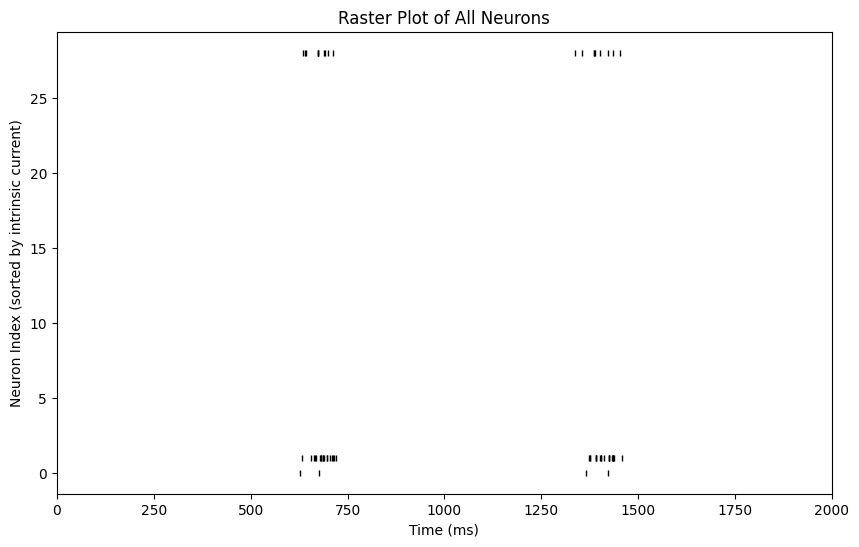

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# combine spike monitor data
all_spike_times = np.concatenate((SpikeMon_exc.t, SpikeMon_inh.t))
all_spike_indices = np.concatenate((SpikeMon_exc.i, SpikeMon_inh.i))

# extract intrinsic current for sorting
intrinsic_current = np.concatenate((StateMon_exc.Imid[:, 0], StateMon_inh.Imid[:, 0]))

# get sorted order of neuron indices based on intrinsic current
sorted_indices = np.argsort(intrinsic_current)

# correct mapping of spike indices
remapped_spike_indices = np.searchsorted(sorted_indices, all_spike_indices)

# create the raster plot
plt.figure(figsize=(10, 6))
plt.plot(all_spike_times / ms, remapped_spike_indices, '|k', markersize=5)  # '|k' for black vertical lines
plt.xlabel('Time (ms)')
plt.xlim(0,2000)
plt.ylabel('Neuron Index (sorted by intrinsic current)')
plt.title('Raster Plot of All Neurons')
plt.show()


# 2. c) Membrane Voltage Heatmap of All Neurons (from StateMon)

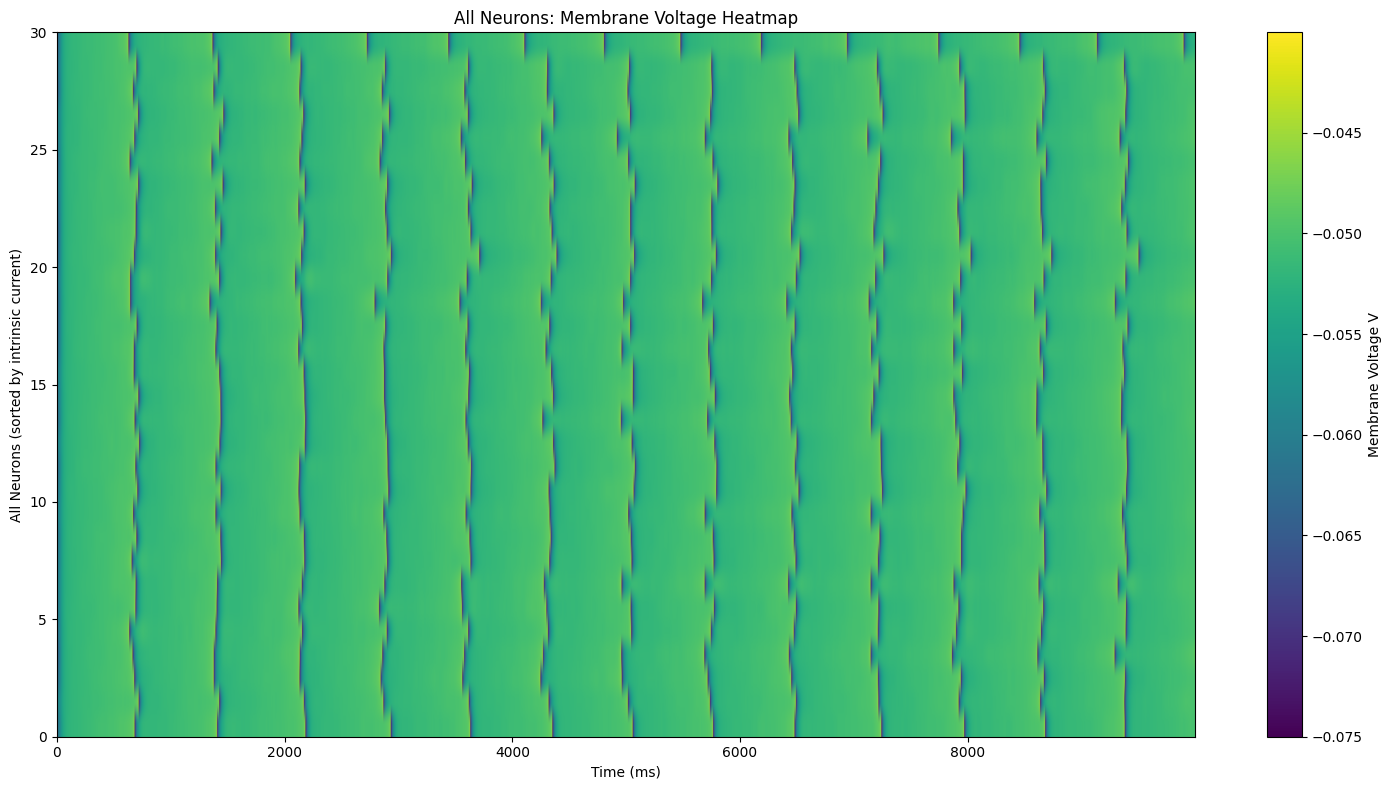

In [26]:
# extract membrane voltage data for all neurons
V_at_each_timepoint = np.vstack((StateMon_exc.V, StateMon_inh.V))

# extract intrinsic current values for sorting
intrinsic_current = np.concatenate((StateMon_exc.Imid[:, 0], StateMon_inh.Imid[:, 0]))

# sort neurons by intrinsic current
sorted_indices = np.argsort(intrinsic_current)

# sort voltage data accordingly
sorted_V = V_at_each_timepoint[sorted_indices, :]

# convert time points to milliseconds
time_values = StateMon_exc.t / ms

# plot membrane voltage heatmap
plt.figure(figsize=(15, 8))
plt.imshow(sorted_V, aspect='auto', cmap='viridis',
           extent=[time_values[0], time_values[-1], 0, sorted_V.shape[0]])  # Correct time scale
plt.colorbar(label='Membrane Voltage V')
plt.xlabel('Time (ms)')
plt.ylabel('All Neurons (sorted by intrinsic current)')
plt.title('All Neurons: Membrane Voltage Heatmap')
plt.tight_layout()
plt.show()


Downsampled version of the voltage heatmap:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract membrane voltage data for all neurons
V_at_each_timepoint = np.vstack((NM.new_StateMon_exc.V, NM.new_StateMon_inh.V))

# Extract intrinsic current values for sorting
intrinsic_current = np.concatenate((NM.new_StateMon_exc.I[:, 0], NM.new_StateMon_inh.I[:, 0]))

# Sort neurons by intrinsic current
sorted_indices = np.argsort(intrinsic_current)

# Sort voltage data accordingly
sorted_V = V_at_each_timepoint[sorted_indices, :]

# Convert time points to milliseconds
time_values = NM.new_StateMon_exc.t / ms

#  **Downsample to avoid crashes**
downsample_factor = 10  # Adjust this (higher = more downsampling)
sorted_V = sorted_V[:, ::downsample_factor]  # Keep every 10th time point
time_values = time_values[::downsample_factor]  # Downsample time axis

# Plot membrane voltage heatmap
plt.figure(figsize=(15, 8))
plt.imshow(sorted_V, aspect='auto', cmap='viridis',
           extent=[time_values[0], time_values[-1], 0, sorted_V.shape[0]])  # Correct time scale
plt.colorbar(label='Membrane Voltage V')
plt.xlabel('Time (ms)')
plt.ylabel('All Neurons (sorted by intrinsic current)')
plt.title('All Neurons: Membrane Voltage Heatmap')
plt.tight_layout()
plt.show()


# 2. d) Mean firing rate, Adaptation, Inhibitory current plots of whole network (to dissect what is causing the bursts)

In [29]:
import matplotlib.pyplot as plt

# **Inhibitory currents**
I_syn_inh_exc = StateMon_exc.I_syn_inh / nA # shape: (N_exc, time)
I_syn_inh_inh = StateMon_inh.I_syn_inh / nA  # shape: (N_inh, time)
I_syn_inh_all = np.concatenate((I_syn_inh_exc, I_syn_inh_inh), axis=0)
mean_I_syn_inh = np.mean(I_syn_inh_all, axis=0)


# **Adaptation**
A_exc = StateMon_exc.A / nA  # shape: (N_exc, time)
A_inh = StateMon_inh.A / nA    # shape: (N_inh, time)
A_all = np.concatenate((A_exc, A_inh), axis=0)
mean_A = np.mean(A_all, axis=0)


# **Mean firing rate**
spike_times_exc = SpikeMon_exc.t / second
spike_times_inh = SpikeMon_inh.t / second
all_spike_times = np.concatenate((spike_times_exc, spike_times_inh))

# bin spikes
bin_width = 0.01  # in seconds
bins = np.arange(0, NM.new_StateMon_exc.t[-1] / second + bin_width, bin_width)
spike_counts, _ = np.histogram(all_spike_times, bins=bins)

# compute mean firing rate (in Hz) per neuron
mean_firing_rate = spike_counts / (N * bin_width)


# **plot**
time = NM.new_StateMon_exc.t / second

fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Inhibitory current plot
axes[0].plot(time, mean_I_syn_inh, color = 'blue')
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Inhibitory Current (nA)")
axes[0].set_title("Mean Inhibitory Current")

# Zoom in to the last 4 seconds
axes[0].set_xlim(4, 8)
axes[0].set_xticks(np.arange(4, 8.1, 1))

# firing rate plot
axes[1].plot(bins[:-1], mean_firing_rate, color = 'green')
axes[1].set_ylabel("Firing rate (Hz)")
axes[1].set_title("Mean Population Firing Rate")
axes[1].set_xlim(4, 8)
axes[1].set_xticks(np.arange(4, 8.1, 1))

# adaptation plot
axes[2].plot(time, mean_A, color = 'red')
axes[2].set_ylabel("Adaptation (nA)")
axes[2].set_title("Mean Adaptation")

axes[2].set_xlim(4, 8)
axes[2].set_xticks(np.arange(4, 8.1, 1))


plt.tight_layout()
plt.show()


NameError: name 'I_syn_inh_exc' is not defined

# Part 3. Neruons Close-Up

# Insert phase plane analysis here maybe? parameter space plot for g_syn_max and I?

# 3. a) Current and voltage traces of a single excitatory neuron

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *

# pick a random excitatory neuron index
#rand_nr = np.random.randint(0, len(StateMon_exc.record))
rand_nr =4
# retrieve current contributions from the random neuron
I_syn_rand = np.array(StateMon_exc.I_syn_exc[rand_nr, :])
#print(I_syn_rand)
#I_leak_rand = np.array(NM.new_StateMon_exc.I_leak[rand_nr, :])
#print(I_leak_rand)
#I_exp_rand = np.array(NM.new_StateMon_exc.I_exp[rand_nr, :])
#print(I_exp_rand)

#retrieve voltage trace of the random neuron
V_rand = np.array(StateMon_exc.V[rand_nr, :])

# Count incoming connections to this specific neuron
# For excitatory inputs
exc_inputs = 0
if hasattr(Syn_EE, 'j'):  # E→E connections
    exc_inputs = sum(Syn_EE.j == rand_nr)  # Count connections where this neuron is the target

# For inhibitory inputs
inh_inputs = 0
if hasattr(Syn_IE, 'j'):  # I→E connections
    inh_inputs = sum(Syn_IE.j == rand_nr)  # Count connections where this neuron is the target

fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# plot the current contributions on the first subplot
ax[0].plot(StateMon_exc.t/ms, I_syn_rand, label='Synaptic Current', color='blue')
#ax[0].plot(NM.new_StateMon_exc.t/ms, I_leak_rand, label='Leakage Current', color='red')
#ax[0].plot(NM.new_StateMon_exc.t/ms, I_exp_rand, label='Exponential Current', color='green')
ax[0].set_xlabel('Time (ms)')
ax[0].set_xlim(0,2000)
ax[0].set_ylabel('Current (A)')
ax[0].set_title(f'Current Contributions of Excitatory Neuron {rand_nr}')
ax[0].legend()

# plot the voltage trace on the second subplot
ax[1].plot(StateMon_exc.t/ms, V_rand/mV, label='Voltage', color='purple')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Voltage (mV)')
ax[1].set_title(f'Voltage Trace of Excitatory Neuron {rand_nr}')
ax[1].legend()
ax[1].set_xlim(0,2000)

plt.tight_layout()
plt.show()

# Add text with connectivity information
plt.figtext(0.5, 0.01,
            f"Neuron {rand_nr} receives {exc_inputs} excitatory and {inh_inputs} inhibitory inputs",
            ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

plt.show()

# Print detailed connectivity information
print(f"\nConnectivity for Excitatory Neuron {rand_nr}:")
print(f"Receiving {exc_inputs} excitatory inputs")
print(f"Receiving {inh_inputs} inhibitory inputs")
print(f"Total inputs: {exc_inputs + inh_inputs}")

# Number of connections per neuron
syn_count = sum(list(synapse_count_per_neuron.values()))
print("\nNetwork-wide statistics:")
print("Total number of synapses:", syn_count)

# Average number of synapses per neuron
average_synapses = syn_count / len(synapse_count_per_neuron)
print("Average synapses per neuron:", average_synapses)


# 3. b) Current and voltage traces of single inhibitory neuron

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *

rand_nr = np.random.randint(0, len(StateMon_inh.record))

I_syn_inh = np.array(StateMon_inh.I_syn_inh[rand_nr, :])
print(I_syn_inh)
#I_leak_inh =  np.array(NM.new_StateMon_inh.I_leak[rand_nr, :])
#I_exp_inh = np.array(NM.new_StateMon_inh.I_exp[rand_nr, :])

V_rand_inh = np.array(StateMon_inh.V[rand_nr, :])

exc_inputs = 0
if hasattr(Syn_IE, 'j'):  # E→E connections
    exc_inputs = sum(Syn_EE.j == rand_nr)  # Count connections where this neuron is the target

# For inhibitory inputs
inh_inputs = 0
if hasattr(Syn_II, 'j'):  # I→E connections
    inh_inputs = sum(Syn_IE.j == rand_nr)  # Count connections where this neuron is the target

fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# plot the current contributions on the first subplot
ax[0].plot(StateMon_inh.t/ms, I_syn_inh, label='Synaptic Current', color='blue')
#ax[0].plot(NM.new_StateMon_inh.t/ms, I_leak_inh, label='Leakage Current', color='red')
#ax[0].plot(NM.new_StateMon_inh.t/ms, I_exp_inh, label='Exponential Current', color='green')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Current (A)')
ax[0].set_title(f'Current Contributions of Inhibitory Neuron {rand_nr}')
ax[0].legend()
ax[0].set_xlim(0,2000)

# plot the voltage trace on the second subplot
ax[1].plot(StateMon_exc.t/ms, V_rand/mV, label='Voltage', color='purple')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Voltage (mV)')
ax[1].set_title(f'Voltage Trace of a Inhibitory Neuron {rand_nr}')
ax[1].legend()
ax[1].set_xlim(0,2000)

plt.tight_layout()
plt.show()

# Print detailed connectivity information
print(f"\nConnectivity for Excitatory Neuron {rand_nr}:")
print(f"Receiving {exc_inputs} excitatory inputs")
print(f"Receiving {inh_inputs} inhibitory inputs")
print(f"Total inputs: {exc_inputs + inh_inputs}")

# Number of connections per neuron
syn_count = sum(list(synapse_count_per_neuron.values()))
print("\nNetwork-wide statistics:")
print("Total number of synapses:", syn_count)

# Average number of synapses per neuron
average_synapses = syn_count / len(synapse_count_per_neuron)
print("Average synapses per neuron:", average_synapses)

# 3. c) Voltage traces plots (from StateMon) of 10 randomly chosen neurons

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

num_exc_to_plot = 8
num_inh_to_plot = 2

exc_indices = np.random.choice(np.arange(N_exc), size=num_exc_to_plot, replace=False)
inh_indices = np.random.choice(np.arange(N_inh), size=num_inh_to_plot, replace=False)

# create subplots for the selected neurons
fig, axes = plt.subplots(num_exc_to_plot + num_inh_to_plot, 1, figsize=(10, 15), sharex=True)

# plot excitatory neurons
for i, exc_idx in enumerate(exc_indices):
    axes[i].plot(NM.new_StateMon_exc.t/ms, NM.new_StateMon_exc.V[exc_idx, :]/mV, label=f'Excitatory {exc_idx}', color='blue')
    axes[i].set_ylabel('V (mV)')
    axes[i].legend(loc="upper right")

# plot inhibitory neurons
for i, inh_idx in enumerate(inh_indices):
    axes[num_exc_to_plot + i].plot(NM.new_StateMon_inh.t/ms, NM.new_StateMon_inh.V[inh_idx, :]/mV, label=f'Inhibitory {inh_idx}', color='red')
    axes[num_exc_to_plot + i].set_ylabel('V (mV)')
    axes[num_exc_to_plot + i].legend(loc="upper right")

# Set common labels
for ax in axes:
    ax.set_ylim([-80, -40])  # Keep voltage range within normal neuron behavior

axes[-1].set_xlabel('Time (ms)')
plt.suptitle('Membrane Potential Traces of Selected Neurons (Excitatory and Inhibitory)')

plt.tight_layout()
plt.show()


# Part 4. Local Field Potential Experiments

# 4. a) Experimental Setup - 2D MEA and Neuronal Grid

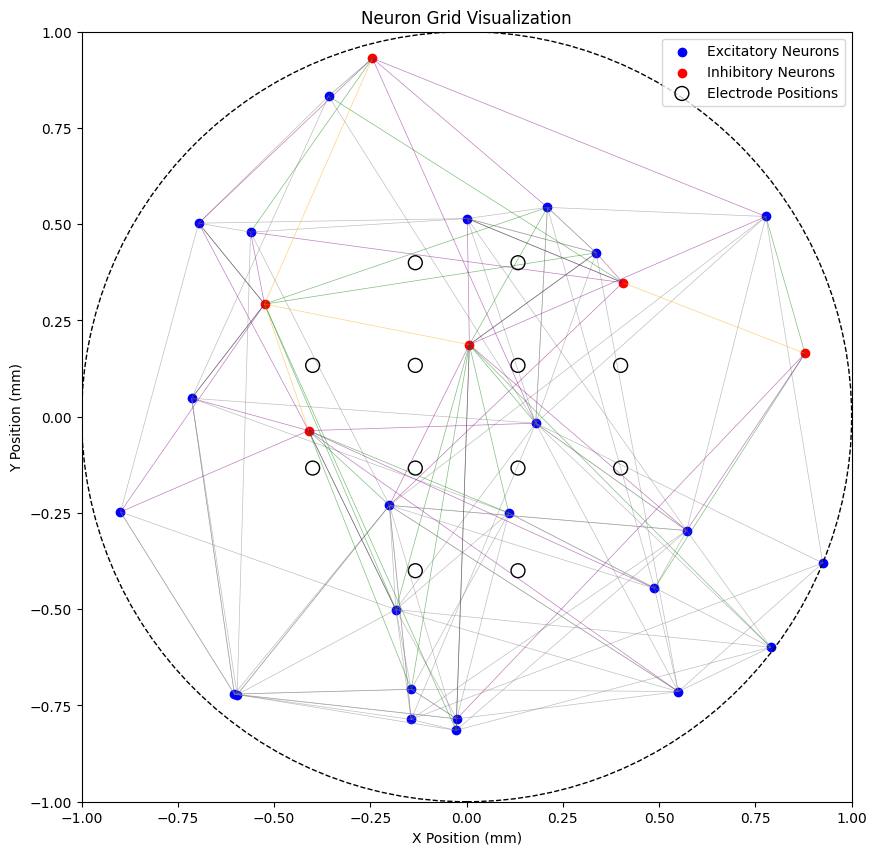

In [3]:
import matplotlib.pyplot as plt

# Get synapse connections from NM
pre_indices_EE = Syn_EE.i[:]
post_indices_EE = Syn_EE.j[:]

pre_indices_EI = Syn_EI.i[:]
post_indices_EI = Syn_EI.j[:]

pre_indices_IE = Syn_IE.i[:]
post_indices_IE = Syn_IE.j[:]

pre_indices_II = Syn_II.i[:]
post_indices_II = Syn_II.j[:]

X_exc = X_position_exc
X_inh = X_position_inh

# Create the plot
plt.figure(figsize=(10, 10))

# Plot excitatory neurons
plt.scatter(X_exc[:, 0], X_exc[:, 1], color='blue', label='Excitatory Neurons')

# Plot inhibitory neurons
plt.scatter(X_inh[:, 0], X_inh[:, 1], color='red', label='Inhibitory Neurons')

# Plot synapses
# EE synapses
for pre_idx, post_idx in zip(pre_indices_EE, post_indices_EE):
    plt.plot([X_exc[pre_idx, 0], X_exc[post_idx, 0]],
             [X_exc[pre_idx, 1], X_exc[post_idx, 1]],
             color='gray', linewidth=0.5, alpha=0.5)

# EI synapses
for pre_idx, post_idx in zip(pre_indices_EI, post_indices_EI):
    plt.plot([X_exc[pre_idx, 0], X_inh[post_idx, 0]],
             [X_exc[pre_idx, 1], X_inh[post_idx, 1]],
             color='green', linewidth=0.5, alpha=0.5)

# IE synapses
for pre_idx, post_idx in zip(pre_indices_IE, post_indices_IE):
    plt.plot([X_inh[pre_idx, 0], X_exc[post_idx, 0]],
             [X_inh[pre_idx, 1], X_exc[post_idx, 1]],
             color='purple', linewidth=0.5, alpha=0.5)

# II synapses
for pre_idx, post_idx in zip(pre_indices_II, post_indices_II):
    plt.plot([X_inh[pre_idx, 0], X_inh[post_idx, 0]],
             [X_inh[pre_idx, 1], X_inh[post_idx, 1]],
             color='orange', linewidth=0.5, alpha=0.5)

# Add circle representing grid edges
circle = plt.Circle((0, 0), gridsize, fill=False, edgecolor='black', linestyle='--')
plt.gca().add_artist(circle)

# Add empty circles for electrodes
plt.scatter(Xe[:, 0], Xe[:, 1], s=100, facecolors='none', edgecolors='black', label="Electrode Positions")

plt.xlim([-gridsize, gridsize])  # Set x-axis limits
plt.ylim([-gridsize, gridsize])  # Set y-axis limits

plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('Neuron Grid Visualization')
plt.legend()
plt.gca().set_aspect('equal')  # Ensure equal aspect ratio for circular grid
plt.show()

# 4. c) Signal Pre-Processing and LFP Time Series (as seen by each electrode)

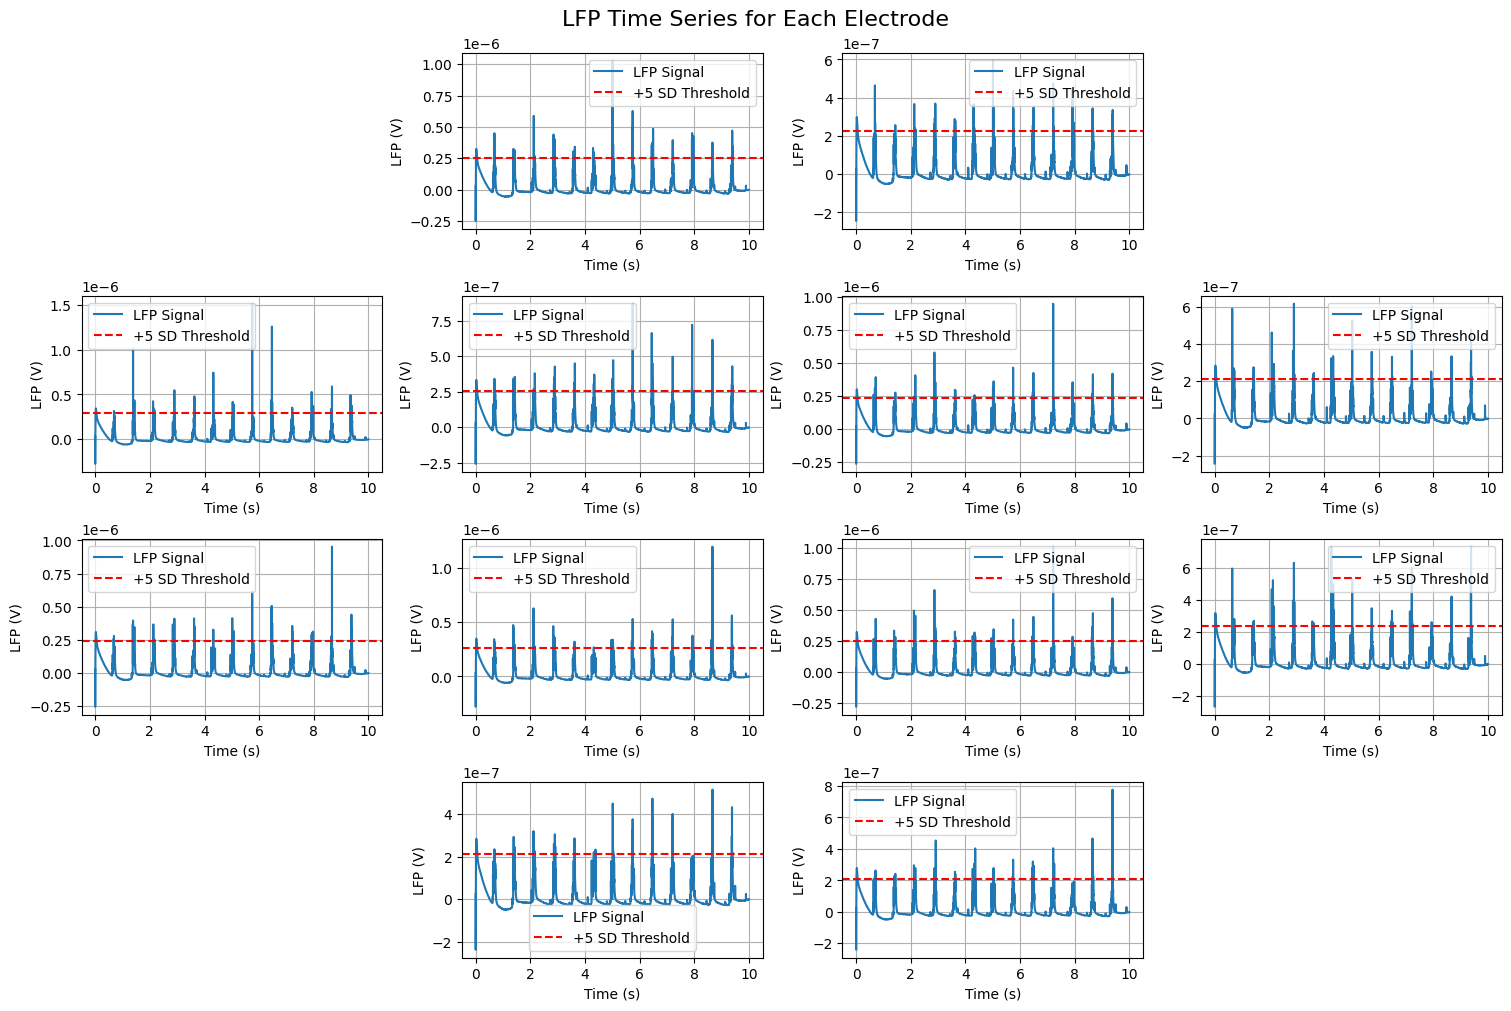

Processed baseline values: [None -8.443964031209279e-10 -7.871406328874621e-10 None
 -8.99156353067435e-10 -8.759579774655856e-10 -8.222504966596819e-10
 -7.684575756084736e-10 -8.172821799691228e-10 -9.164685799658983e-10
 -8.826367143898694e-10 -8.613961579200779e-10 None -7.557953317999052e-10
 -7.573259153843031e-10 None]
Processed standard deviations: [None 5.113052759687664e-08 4.55278700413298e-08 None
 5.777500849961447e-08 5.1933587411884644e-08 4.677162236437447e-08
 4.206204419737591e-08 4.768965221719525e-08 5.297130426792156e-08
 4.990002093637749e-08 4.809781290220185e-08 None 4.228032407527569e-08
 4.240380728476628e-08 None]


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.ndimage import gaussian_filter

# define a high-pass filter function
def highpass_filter(signal, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normalized_cutoff = cutoff / nyquist  # normalized cutoff frequency
    b, a = butter(order, normalized_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

#fFilter parameters
fs = 1000  # sampling frequency [samples/second]
cutoff_frequency = 0.5
transient_cutoff = 3*fs #cutoff frequency for transient removal

#extractLFPdata
elecs = np.array(ElecMon.LFP)

# empty indices (where electrodes are not present)
empty_indices = [0, 3, 12, 15]

# reshape and process data
elec_array = np.full((16, 10000), None, dtype=object)
baseline = []
std_dev = []
threshold_positive = []
#threshold_negative = []

elec_index = 0
for i in range(16):
  if i not in empty_indices:
    # apply filtering
    filtered_signal = highpass_filter(elecs[elec_index], cutoff_frequency, fs)
    elec_array[i] = filtered_signal

    # exclude transient and calculate baseline and SD
    signal_without_transient = filtered_signal[transient_cutoff:]
    baseline_mean = np.mean(signal_without_transient)
    baseline.append(baseline_mean)
    std = np.std(signal_without_transient)
    std_dev.append(std)

    #calucalte thresholds
    threshold_positive.append(baseline_mean + 5*std)
    #threshold_negative.append(baseline_mean - 5*std)

    elec_index += 1

  else:
    baseline.append(None)
    std_dev.append(None)
    threshold_positive.append(None)
    #threshold_negative.append(None)

# convert lists to arrays for indexing
baseline = np.array(baseline)
std_dev = np.array(std_dev)
threshold_positive = np.array(threshold_positive)
#threshold_negative = np.array(threshold_negative)

# time vector for plotting
time = np.linspace(0, 10, elec_array[1].shape[0])

# plot LFP time series for each electrode
fig, axes = plt.subplots(4, 4, figsize=(15, 10), constrained_layout=True)

for i, ax in enumerate(axes.flat):
  if elec_array[i] is not None:
    ax.plot(time, elec_array[i], label="LFP Signal")

    # plot thresholds
    if threshold_positive[i] is not None:
      ax.axhline(y=threshold_positive[i], color='r', linestyle='--', label="+5 SD Threshold")

    #if threshold_negative[i] is not None:
      #ax.axhline(y=threshold_negative[i], color='b', linestyle='--', label="-5 SD Threshold")

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("LFP (V)")
    ax.grid()
    ax.legend()

  else:
    ax.set_visible(False)


# set the overall figure title
fig.suptitle("LFP Time Series for Each Electrode", fontsize=16)

#hide empty plots
axes[0, 0].set_visible(False)
axes[0, 3].set_visible(False)
axes[3, 0].set_visible(False)
axes[3, 3].set_visible(False)

# Show the plot
plt.show()

#print(len(axes.flat))

print("Processed baseline values:", baseline)
print("Processed standard deviations:", std_dev)


LFP Time-series for simulations after the transient

In [ ]:
# Option 1 -> if I use NM function for obtaining data after the transient

def highpass_filter(signal, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normalized_cutoff = cutoff / nyquist  # normalized cutoff frequency
    b, a = butter(order, normalized_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

#fFilter parameters
fs = 1000  # sampling frequency [samples/second]
cutoff_frequency = 0.5
transient_cutoff = 3*fs #cutoff frequency for transient removal

#extractLFPdata
elecs = np.array(NM.new_ElecMon.LFP)

filtered_signal = highpass_filter(elecs[0, :], cutoff_frequency, fs)

lfp_trace = NM.new_ElecMon.LFP[0, :]
plt.figure(figsize=(10, 5))
plt.plot(NM.new_StateMon_exc.t/ms, lfp_trace, label='LFP')
plt.show()

In [ ]:
# Option 2 -> Restoring the network saved after 2 seconds and running the model without the transient here to obtain measurements after the transient

# define a high-pass filter function
def highpass_filter(signal, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normalized_cutoff = cutoff / nyquist  # normalized cutoff frequency
    b, a = butter(order, normalized_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)


# restore the state from 2 seconds
net.restore(name='state_at_2s')
print("Network state restored to 2 seconds.")

#create a new monitor of electrodes only for the time after the transient and add it to the network
empty_ElecMon = StateMonitor(ELEC, variables = 'LFP', record = True, dt = 1*ms)
net.add(empty_ElecMon)

#run the simulation after the transient
runtime_without_transient = 8*second
net.run(runtime_without_transient)

#filter parameters
cutoff_frequency = 0.5
fs = 1000  # sampling frequency [samples/second]

#extractLFPdata
elecs2 = np.array(empty_ElecMon.LFP)

# empty indices (where electrodes are not present)
empty_indices = [0, 3, 12, 15]

# reshape and process data
elec_array2 = np.full((16, 8000), None, dtype=object)
baseline = []
std_dev = []
threshold_positive = []
#threshold_negative = []

elec_index = 0
for i in range(16):
  if i not in empty_indices:
    # apply filtering
    filtered_signal2 = highpass_filter(elecs2[elec_index], cutoff_frequency, fs)
    elec_array2[i] = filtered_signal2

    # exclude transient and calculate baseline and SD
    baseline_mean = np.mean(filtered_signal2)
    baseline.append(baseline_mean)
    std = np.std(filtered_signal2)
    std_dev.append(std)

    #calucalte thresholds
    threshold_positive.append(baseline_mean + 5*std)
    #threshold_negative.append(baseline_mean - 5*std)

    elec_index += 1

  else:
    baseline.append(None)
    std_dev.append(None)
    threshold_positive.append(None)
    #threshold_negative.append(None)

# convert lists to arrays for indexing
baseline = np.array(baseline)
std_dev = np.array(std_dev)
threshold_positive = np.array(threshold_positive)
#threshold_negative = np.array(threshold_negative)

# time vector for plotting
time2 = np.linspace(2, 10, elec_array2[1].shape[0])

# plot LFP time series for each electrode
fig, axes = plt.subplots(4, 4, figsize=(15, 10), constrained_layout=True)

for i, ax in enumerate(axes.flat):
  if elec_array2[i] is not None:
    ax.plot(time2, elec_array2[i], label="LFP Signal")

    # plot thresholds
    if threshold_positive[i] is not None:
      ax.axhline(y=threshold_positive[i], color='r', linestyle='--', label="+5 SD Threshold")

    #if threshold_negative[i] is not None:
      #ax.axhline(y=threshold_negative[i], color='b', linestyle='--', label="-5 SD Threshold")

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("LFP (V)")
    ax.grid()
    ax.legend()

  else:
    ax.set_visible(False)


# set the overall figure title
fig.suptitle("LFP Time Series for Each Electrode", fontsize=16)

#hide empty plots
axes[0, 0].set_visible(False)
axes[0, 3].set_visible(False)
axes[3, 0].set_visible(False)
axes[3, 3].set_visible(False)

# Show the plot
plt.show()

#print(len(axes.flat))

print("Processed baseline values:", baseline)
print("Processed standard deviations:", std_dev)

# 4. c) Raster plot from LFP data

[  13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27   28   29   30   31   32   33   34   35   36   37   38   39   40
   41   42   43   44   45   46   47   48   49   50  687 1385 1433 1435
 2125 2126 2128 2130 2164 2850 2897 2898 3575 3617 3629 4295 4322 5007
 5030 5031 5744 5748 6443 6454 6466 6476 6492 7210 7220 7914 7920 7966
 7975 8664 8671 9379 9387 9388 9389 9390 9391 9392 9394 9397]
[  13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27   28   29   30   31   32   33   34   35   36   37   38   39   40
   41   42   43   44   45   46   47   48   49   50   51   52   53  687
  696 1433 1435 2126 2130 2137 2166 2170 2850 2864 2878 2897 2898 3607
 3617 3629 4295 4302 4322 5007 5030 5031 5744 5748 5763 6466 6476 6486
 6492 7210 7220 7914 7920 7966 8655 8664 9373 9379 9387 9389 9390 9397]
[  14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43  68

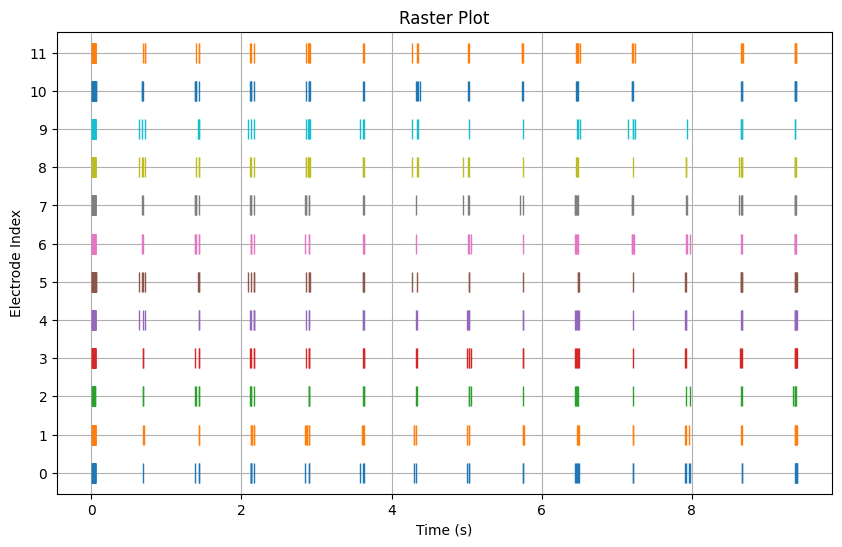

In [8]:
#initialize spike times for each electrode
spike_times = [[] for _ in range(16)]
excluded_electrodes = [3, 12]
y_position = 0

for i in range(16):
  if elec_array[i] is not None and threshold_positive[i] is not None:
    spikes = np.where(elec_array[i] > threshold_positive[i])[0] # find times where LFP surpasses the positive threshold
    spike_times[i] = time[spikes]
    print(spikes)

#plot the raster plot
fig, ax = plt.subplots(figsize = (10, 6))

for i, spikes in enumerate(spike_times):
  if (np.array(spikes).size>0) and (i not in excluded_electrodes):
      ax.plot(spikes, [y_position] * len(spikes), '|', markersize = 15, label=f"Electrode {i + 1}")
      y_position+=1

ax.set_xlabel("Time (s)")
ax.set_ylabel("Electrode Index")
ax.set_title("Raster Plot")
ax.set_yticks(range(y_position))  # Set y-ticks to match the included electrodes
#ax.set_yticklabels([f"Electrode {i + 1}" for i in range(16) if i not in excluded_electrodes])  # Label included electrodes
ax.grid(True)
plt.show()


# 4. b) Average and Real-Time LFP Heatmaps -> FIX THIS, maybe make 3D?

In [ ]:
#Heatmap of mean LFPs on the grid
import numpy as np
import matplotlib.pyplot as plt

sigma2 = 2
grid_size = 1 #mm
grid_resolution = 50 # number of grid points per axis for higher resolution
x_grid = np.linspace(0, grid_size, grid_resolution) #mm
y_grid = np.linspace(0, grid_size, grid_resolution) #mm
very_small_r = 1e-3

#Create MxM matrix where M is the number of 'electrodes' or points on the grid
xx, yy = np.meshgrid(x_grid, y_grid)

#initialize grid for storing LFP values
LFP_grid = np.zeros((grid_resolution, grid_resolution))

#flatten the matrix into a vector
x_E = xx.flatten()
y_E = yy.flatten()

#create two vectors for x and y positions of neurons
# Combine the x-coordinates (x1) of both neuron populations
x_N = np.concatenate([Pop_exc.x1, Pop_inh.x1])

# Combine the y-coordinates (x2) of both neuron populations
y_N = np.concatenate([Pop_exc.x2, Pop_inh.x2])

#calculate the distance between x positions of neurons and gridpoints
dx = x_E[:, None] - x_N[None,:]

#calculate the distance between y positions of neurons and gridpoints
dy = y_E[:, None] - y_N[None,:]

#calculate the radius
r = np.sqrt(dx**2 + dy**2) #mm not #mm**2
r[r < very_small_r] = very_small_r
print(r)

#calucalte the current contribution from every neuron
I_sum = I_mean_sum[None, :]/nA/(4 * np.pi * sigma2 * r) #LFP has units mV/meter
print(I_sum)

#sum the current contributions from each neuron for each gridpoint reseahpe back into MxM matrix
elec_grid = I_sum.sum(axis=1).reshape(grid_resolution, grid_resolution)

#plot the heatmap
plt.imshow(elec_grid, origin='lower', cmap='hot', extent=(0, gridsize, 0, gridsize), )
#heatmap = plt.imshow(elec_grid, origin='lower', cmap='hot', extent=(0, gridsize, 0, gridsize))
#heatmap.set_clim(0, 14)  # Minimum and maximum values for the color scale

plt.xlabel("x position (mm)")
plt.ylabel("y position (mm)")
plt.title("Heatmap of mean LFPs")
#plt.set_clim([0,14])

cbar = plt.colorbar()
cbar.set_label('LFP (mV)')

In [ ]:
#FIx this or delete?
#Heatmap of mean LFPs on the grid
import numpy as np
import matplotlib.pyplot as plt

sigma2 = 2
grid_size = 1 #mm
grid_resolution = 500 # number of grid points per axis for higher resolution
x_grid = np.linspace(0, grid_size, grid_resolution) #mm
y_grid = np.linspace(0, grid_size, grid_resolution) #mm
very_small_r2 = 1e-6

#Create MxM matrix where M is the number of 'electrodes' or points on the grid
xx, yy = np.meshgrid(x_grid, y_grid)

#initialize grid for storing LFP values
LFP_grid = np.zeros((grid_resolution, grid_resolution))

#flatten the matrix into a vector
x_E = xx.flatten()
y_E = yy.flatten()

#create two vectors for x and y positions of neurons
x_N = neuron_positions[:, 0] #mm
y_N = neuron_positions[:, 1] #mm

#calculate the distance between x positions of neurons and gridpoints
dx = x_E[:, None] - x_N[None,:]

#calculate the distance between y positions of neurons and gridpoints
dy = y_E[:, None] - y_N[None,:]

#calculate the radius
r2 = dx**2 + dy**2 #mm**2
r2[r2 < 0.001] = very_small_r2


#calucalte the current contribution from every neuron
I_sum2 = I_mean_sum[None, :]/nA/(4 * np.pi * sigma2 * r2) #LFP has units mV/meter

#sum the current contributions from each neuron for each gridpointreseahpe back into MxM matrix
elec_grid = I_sum2.sum(axis=1).reshape(grid_resolution, grid_resolution)
#elec_grid = np.clip(elec_grid, 0, 50)
#elec_grid[elec_grid>10] = 10

#plot the heatmap
plt.imshow(elec_grid, origin='lower', cmap='hot', extent=(0, gridsize, 0, gridsize))
plt.xlabel("x position (mm)")
plt.ylabel("y position (mm)")
plt.title("Heatmap of mean LFPs")


cbar = plt.colorbar()
cbar.set_label('LFP (mV)')

In [ ]:
!mkdir -p /tmp/video

#print(f'{3:05d}')

import tqdm

!ls /tmp/video



In [ ]:
#Heatmap of LFPs in real time
from google.colab import files
very_small_r2 = 0.001


time_steps = 100

for k, i in enumerate(tqdm.tqdm(range(0, time_steps, 33))):
  I_sum3 = I_sum_at_each_timepoint[:, i]/(4 * np.pi * sigma2 * r2) * 1e9
  #sum the current contributions from each neuron for each gridpoint and reseahpe back into MxM matrix
  elec_grid = I_sum3.sum(axis=1).reshape(grid_resolution, grid_resolution)

  #make sure nothing weird happens at gridpoints very close to the neurons
  elec_grid[elec_grid > 20] = 20

  #plot the heatmap
  plt.clf()
  plt.imshow(elec_grid, origin='lower', cmap='hot', extent=(0, gridsize, 0, gridsize))#, vmin=1e-2, vmax=1e-2)
  plt.savefig(f'/tmp/video/{k:06d}.png')
  plt.xlabel("x position (mm)")
  plt.ylabel("y position (mm)")
  plt.title("Heatmap of mean LFPs")

  cbar = plt.colorbar()
  cbar.set_label('LFP (mV)')
  #plt.show()

! ffmpeg -framerate 30 -i /tmp/video/%06d.png -c:v libx264 -pix_fmt yuv420p -vf "fps=30" -y output_video.mp4
from IPython.display import Video

# Display the video in the notebook
Video("output_video.mp4", embed=True)

files.download("output_video.mp4")

# Part 5. Data Analysis - LFP Metrics

# 5. a) Synchronicity measures

In [16]:
!pip install matplotlib-venn

In [10]:
!apt-get -qq install -y libfluidsynth1

E: Package 'libfluidsynth1' has no installation candidate


In [11]:
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 125044 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.6.0-1ubuntu1.3_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.6.0-1ubuntu1.3) ...
Setting up libarchive-dev:amd64 (3.6.0-1ubuntu1.3) ...
Processing triggers for man-db (2.10.2-1) ...
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 10.8 MB/s eta 0:00:00
  Created wheel for libarchive: filename=libarchive-0.4.7-py3-none-any.whl size=31631 sha256=3db3f50f11fccf3ddddfbd49ed06bc41eb4b114f33d5cd4477aed57f6db5e630
  Stored in directory: /root/.cache/pip/wheels/32/98/bd/4893d6923dd027f455b250367d402bfd69a6f4416581df46db
Successfully built libarchive


In [12]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install pydot
import pydot

In [13]:
!pip install cartopy
import cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 26.9 MB/s eta 0:00:00



=== LFP SPIKE ANALYSIS SUMMARY ===
Electrode 2:
  - Firing Rate: 3.70 Hz
  - Number of Spikes: 37
  - Mean ISI: 0.2607 s
  - Median ISI: 0.0305 s
  - CV of ISI: 1.2452

Electrode 3:
  - Firing Rate: 4.10 Hz
  - Number of Spikes: 41
  - Mean ISI: 0.2346 s
  - Median ISI: 0.0140 s
  - CV of ISI: 1.3709

Electrode 5:
  - Firing Rate: 3.50 Hz
  - Number of Spikes: 35
  - Mean ISI: 0.2758 s
  - Median ISI: 0.0280 s
  - CV of ISI: 1.2023

Electrode 6:
  - Firing Rate: 3.90 Hz
  - Number of Spikes: 39
  - Mean ISI: 0.2470 s
  - Median ISI: 0.0175 s
  - CV of ISI: 1.3157

Electrode 7:
  - Firing Rate: 3.90 Hz
  - Number of Spikes: 39
  - Mean ISI: 0.2470 s
  - Median ISI: 0.0150 s
  - CV of ISI: 1.3186

Electrode 8:
  - Firing Rate: 3.60 Hz
  - Number of Spikes: 36
  - Mean ISI: 0.2682 s
  - Median ISI: 0.0330 s
  - CV of ISI: 1.2259

Electrode 9:
  - Firing Rate: 3.90 Hz
  - Number of Spikes: 39
  - Mean ISI: 0.2468 s
  - Median ISI: 0.0185 s
  - CV of ISI: 1.3028

Electrode 10:
  - Firing R

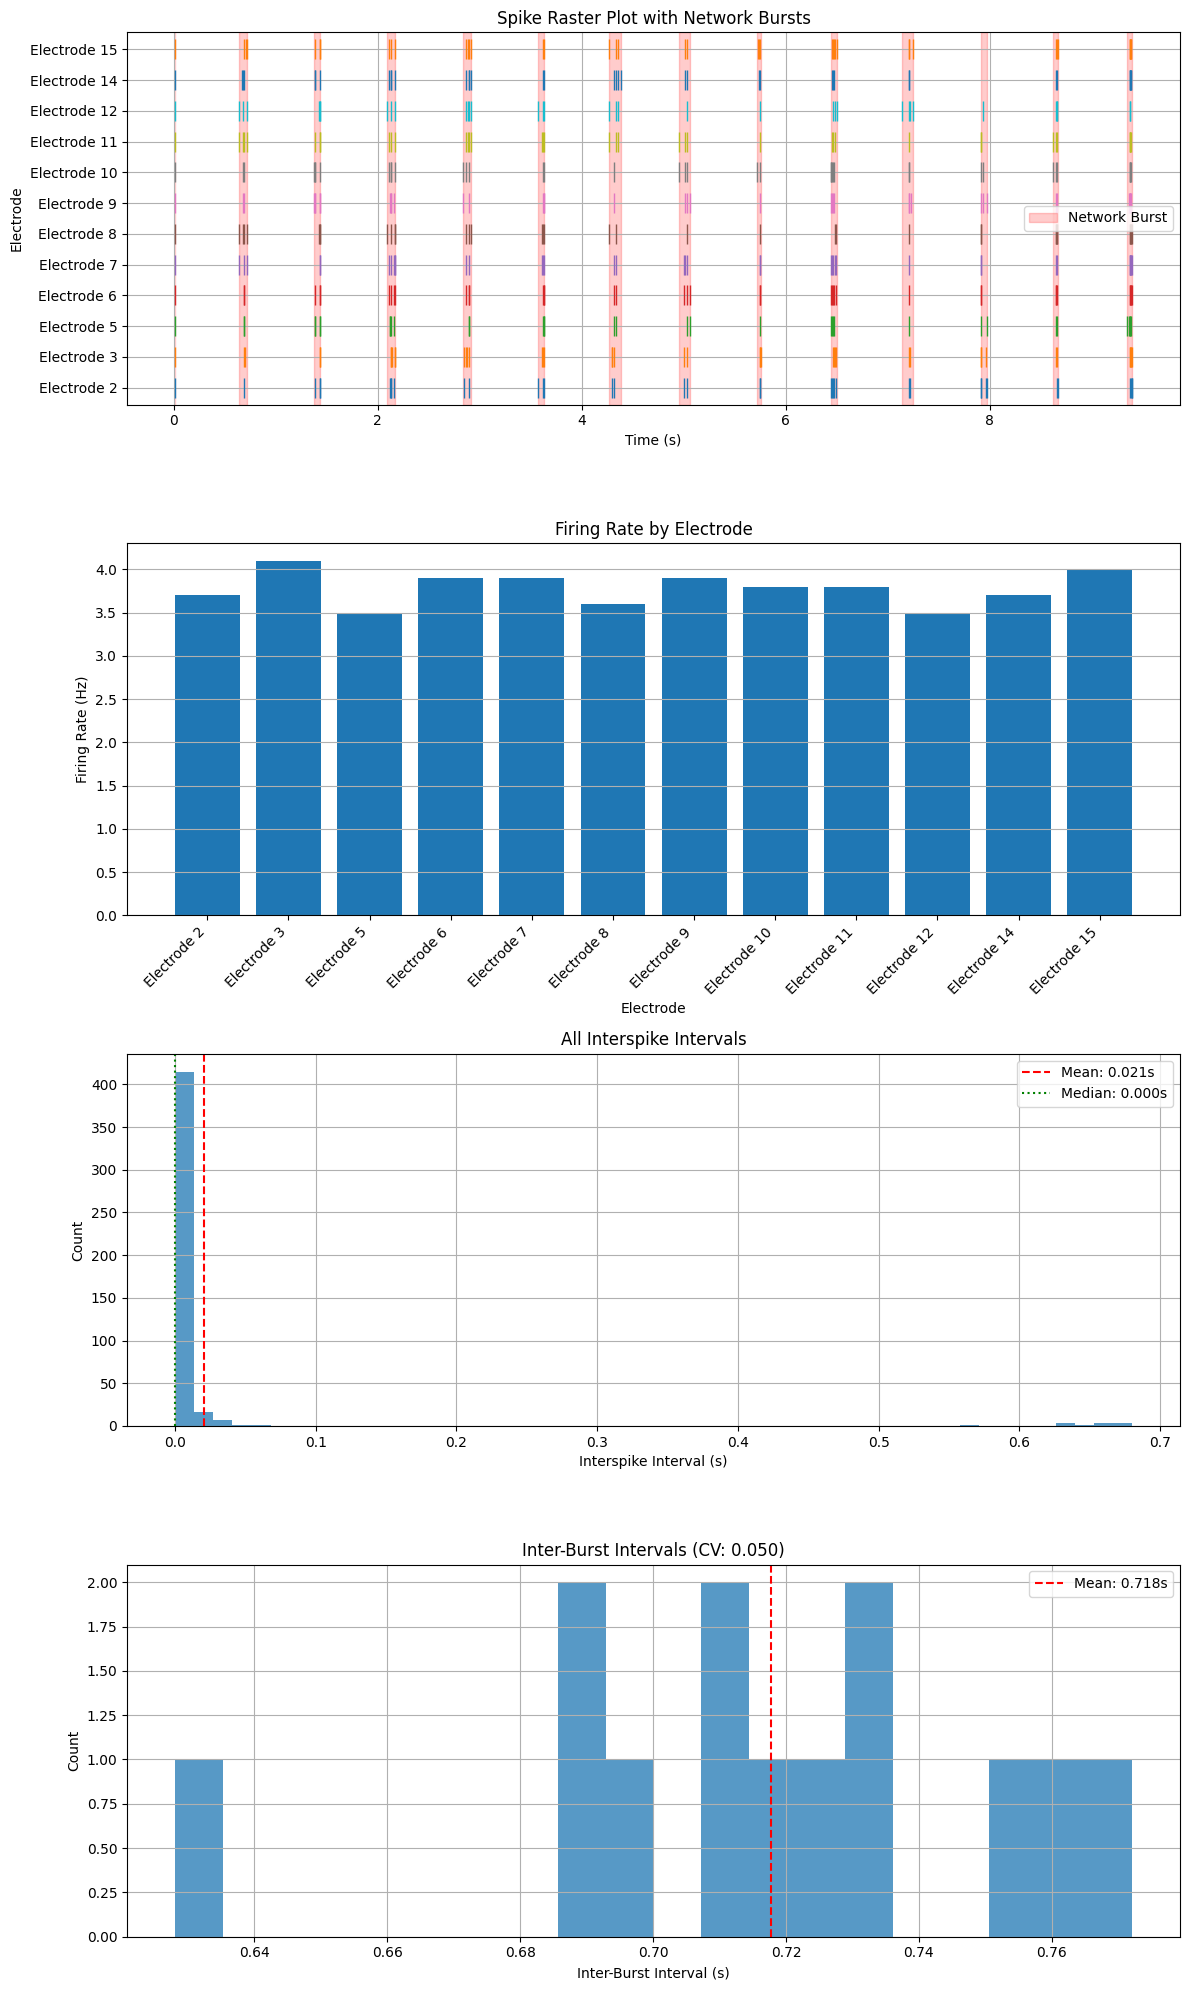

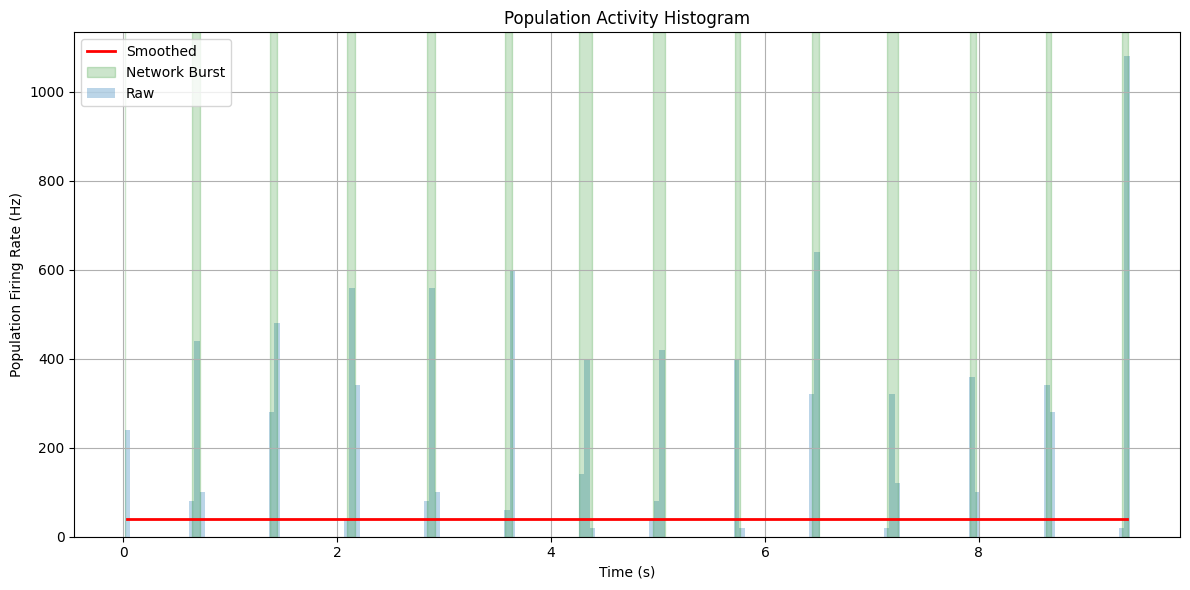


Analysis complete!


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

# Function to calculate firing rate (frequency) from spike times
def calculate_firing_rate(spike_times, total_duration):
    """
    Calculate the firing rate from spike times

    Parameters:
    -----------
    spike_times : array-like
        Times (in seconds) when spikes occur
    total_duration : float
        Total duration of the recording in seconds

    Returns:
    --------
    float
        Firing rate in Hz (spikes per second)
    """
    if len(spike_times) <= 1:
        return 0.0

    # Count spikes and divide by total duration
    return len(spike_times) / total_duration

# Function to calculate interspike intervals
def calculate_isi(spike_times):
    """
    Calculate interspike intervals

    Parameters:
    -----------
    spike_times : array-like
        Times (in seconds) when spikes occur

    Returns:
    --------
    numpy.ndarray
        Array of interspike intervals in seconds
    """
    if len(spike_times) <= 1:
        return np.array([])

    # Calculate differences between consecutive spike times
    return np.diff(spike_times)

# Function to detect threshold crossings in a signal
def detect_threshold_crossings(signal, threshold, time):
    """
    Detect when a signal crosses a threshold

    Parameters:
    -----------
    signal : numpy.ndarray
        The signal to analyze
    threshold : float
        The threshold value
    time : numpy.ndarray
        Time points corresponding to the signal

    Returns:
    --------
    numpy.ndarray
        Times when the signal crosses the threshold
    """
    # Find indices where the signal crosses the threshold
    above_threshold = signal > threshold
    # Find the rising edges (transitions from below to above threshold)
    crossings = np.where(np.diff(above_threshold.astype(int)) > 0)[0]

    # Convert indices to actual time points
    if len(crossings) > 0:
        return time[crossings]
    else:
        return np.array([])

# Function to detect network bursts from spike times
def detect_network_bursts(all_spikes, min_burst_size=3, max_isi_in_burst=0.1):
    """
    Detect network bursts from spike times

    Parameters:
    -----------
    all_spikes : array-like
        All spike times across the network, sorted
    min_burst_size : int
        Minimum number of spikes in a burst
    max_isi_in_burst : float
        Maximum interspike interval within a burst (seconds)

    Returns:
    --------
    list of dicts
        Each dict contains information about a burst (start_time, end_time, spikes)
    """
    if len(all_spikes) < min_burst_size:
        return []

    # Sort spikes by time
    sorted_spikes = np.sort(all_spikes)

    # Calculate interspike intervals
    isis = np.diff(sorted_spikes)

    # Initialize variables
    bursts = []
    current_burst = {'start_time': sorted_spikes[0], 'spikes': [sorted_spikes[0]]}

    # Iterate through spikes to identify bursts
    for i in range(len(isis)):
        if isis[i] <= max_isi_in_burst:
            # Add spike to current burst
            current_burst['spikes'].append(sorted_spikes[i+1])
        else:
            # End current burst
            if len(current_burst['spikes']) >= min_burst_size:
                current_burst['end_time'] = current_burst['spikes'][-1]
                current_burst['duration'] = current_burst['end_time'] - current_burst['start_time']
                current_burst['spike_count'] = len(current_burst['spikes'])

                # Calculate intra-burst firing rate
                if current_burst['duration'] > 0:
                    current_burst['firing_rate'] = current_burst['spike_count'] / current_burst['duration']
                else:
                    current_burst['firing_rate'] = float('inf')

                bursts.append(current_burst)

            # Start new burst
            current_burst = {'start_time': sorted_spikes[i+1], 'spikes': [sorted_spikes[i+1]]}

    # Check if the last burst is valid
    if len(current_burst['spikes']) >= min_burst_size:
        current_burst['end_time'] = current_burst['spikes'][-1]
        current_burst['duration'] = current_burst['end_time'] - current_burst['start_time']
        current_burst['spike_count'] = len(current_burst['spikes'])

        # Calculate intra-burst firing rate
        if current_burst['duration'] > 0:
            current_burst['firing_rate'] = current_burst['spike_count'] / current_burst['duration']
        else:
            current_burst['firing_rate'] = float('inf')

        bursts.append(current_burst)

    return bursts

# Main analysis code
def analyze_lfp_spikes(elec_array, threshold_positive, time_vector, excluded_electrodes=[0, 3, 12, 15],
                      min_burst_size=3, max_isi_in_burst=0.1):
    """
    Analyze LFP data for spikes, calculate firing rates and ISIs

    Parameters:
    -----------
    elec_array : numpy.ndarray
        Array of LFP signals for each electrode
    threshold_positive : numpy.ndarray
        Positive thresholds for spike detection for each electrode
    time_vector : numpy.ndarray
        Time points corresponding to the signals
    excluded_electrodes : list
        List of electrode indices to exclude from analysis
    min_burst_size : int
        Minimum number of spikes in a burst
    max_isi_in_burst : float
        Maximum interspike interval within a burst (seconds)

    Returns:
    --------
    tuple
        (spike_times, firing_rates, isis, bursts)
    """
    total_duration = time_vector[-1] - time_vector[0]
    n_electrodes = len(elec_array)

    # Initialize lists to store results
    spike_times = [[] for _ in range(n_electrodes)]
    firing_rates = np.zeros(n_electrodes)
    isis = [[] for _ in range(n_electrodes)]

    # Process each electrode
    for i in range(n_electrodes):
        if i not in excluded_electrodes and elec_array[i] is not None and threshold_positive[i] is not None:
            # Detect threshold crossings
            spikes = detect_threshold_crossings(elec_array[i], threshold_positive[i], time_vector)

            # Store spike times
            spike_times[i] = spikes

            # Calculate firing rate
            firing_rates[i] = calculate_firing_rate(spikes, total_duration)

            # Calculate interspike intervals
            isis[i] = calculate_isi(spikes)

    # Collect all spikes across the network
    all_spikes = np.sort(np.concatenate([spikes for spikes in spike_times if len(spikes) > 0]))

    # Detect network bursts
    bursts = detect_network_bursts(all_spikes, min_burst_size, max_isi_in_burst)

    return spike_times, firing_rates, isis, bursts, all_spikes

# Function to calculate burst statistics
def calculate_burst_statistics(bursts, total_duration):
    """
    Calculate statistics from detected bursts

    Parameters:
    -----------
    bursts : list of dicts
        List of detected bursts with their properties
    total_duration : float
        Total duration of the recording in seconds

    Returns:
    --------
    dict
        Dictionary containing burst statistics
    """
    if len(bursts) < 2:
        return {
            'burst_rate': 0,
            'mean_burst_duration': 0,
            'mean_spikes_per_burst': 0,
            'mean_intra_burst_firing_rate': 0,
            'mean_inter_burst_interval': 0,
            'cv_inter_burst_interval': 0
        }

    # Calculate burst rate
    burst_rate = len(bursts) / total_duration

    # Calculate mean burst duration
    burst_durations = [burst['duration'] for burst in bursts]
    mean_burst_duration = np.mean(burst_durations)

    # Calculate mean number of spikes per burst
    spikes_per_burst = [burst['spike_count'] for burst in bursts]
    mean_spikes_per_burst = np.mean(spikes_per_burst)

    # Calculate mean intra-burst firing rate
    intra_burst_firing_rates = [burst['firing_rate'] for burst in bursts]
    mean_intra_burst_firing_rate = np.mean(intra_burst_firing_rates)

    # Calculate inter-burst intervals
    burst_start_times = [burst['start_time'] for burst in bursts]
    ibis = np.diff(burst_start_times)
    mean_inter_burst_interval = np.mean(ibis)

    # Calculate coefficient of variation of inter-burst intervals
    std_inter_burst_interval = np.std(ibis)
    cv_inter_burst_interval = std_inter_burst_interval / mean_inter_burst_interval if mean_inter_burst_interval > 0 else 0

    return {
        'burst_rate': burst_rate,
        'mean_burst_duration': mean_burst_duration,
        'mean_spikes_per_burst': mean_spikes_per_burst,
        'mean_intra_burst_firing_rate': mean_intra_burst_firing_rate,
        'mean_inter_burst_interval': mean_inter_burst_interval,
        'cv_inter_burst_interval': cv_inter_burst_interval
    }

# Function to plot the results
def plot_results(spike_times, firing_rates, isis, bursts, all_spikes, burst_stats, excluded_electrodes=[0, 3, 12, 15]):
    """
    Create plots for spike and burst analysis results
    """
    """
    Create plots for spike and burst analysis results

    Parameters:
    -----------
    spike_times : list
        List of arrays containing spike times for each electrode
    firing_rates : numpy.ndarray
        Array of firing rates for each electrode
    isis : list
        List of arrays containing interspike intervals for each electrode
    bursts : list of dicts
        List of detected bursts with their properties
    all_spikes : array-like
        All spike times across the network
    burst_stats : dict
        Dictionary containing burst statistics
    excluded_electrodes : list
        List of electrode indices to exclude from plots
    """
    # Create a figure with subplots
    fig, axs = plt.subplots(4, 1, figsize=(12, 20))

    # 1. Plot raster plot with bursts highlighted
    y_position = 0
    electrode_labels = []
    for i, spikes in enumerate(spike_times):
        if i not in excluded_electrodes and len(spikes) > 0:
            axs[0].plot(spikes, [y_position] * len(spikes), '|', markersize=15)
            electrode_labels.append(f"Electrode {i+1}")
            y_position += 1

    # Highlight burst regions
    for burst in bursts:
        axs[0].axvspan(burst['start_time'], burst['end_time'],
                     alpha=0.2, color='red', label='_' if 'label_added' in locals() else 'Network Burst')
        label_added = True

    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Electrode")
    axs[0].set_title("Spike Raster Plot with Network Bursts")
    axs[0].set_yticks(range(len(electrode_labels)))
    axs[0].set_yticklabels(electrode_labels)
    if len(bursts) > 0:
        axs[0].legend()
    axs[0].grid(True)

    # 2. Plot firing rates
    valid_electrodes = [i for i in range(len(firing_rates)) if i not in excluded_electrodes and firing_rates[i] > 0]
    valid_rates = [firing_rates[i] for i in valid_electrodes]
    electrode_labels = [f"Electrode {i+1}" for i in valid_electrodes]

    axs[1].bar(electrode_labels, valid_rates)
    axs[1].set_xlabel("Electrode")
    axs[1].set_ylabel("Firing Rate (Hz)")
    axs[1].set_title("Firing Rate by Electrode")
    plt.setp(axs[1].get_xticklabels(), rotation=45, ha="right")
    axs[1].grid(True, axis='y')

    # 3. Plot ISI histogram (all ISIs, both within and between bursts)
    all_isis_flat = np.diff(all_spikes)
    if len(all_isis_flat) > 0:
        axs[2].hist(all_isis_flat, bins=50, alpha=0.75)
        axs[2].set_xlabel("Interspike Interval (s)")
        axs[2].set_ylabel("Count")
        axs[2].set_title("All Interspike Intervals")

        # Add mean and median ISI information
        mean_isi = np.mean(all_isis_flat)
        median_isi = np.median(all_isis_flat)
        axs[2].axvline(mean_isi, color='r', linestyle='--', label=f'Mean: {mean_isi:.3f}s')
        axs[2].axvline(median_isi, color='g', linestyle=':', label=f'Median: {median_isi:.3f}s')
        axs[2].legend()
        axs[2].grid(True)
    else:
        axs[2].text(0.5, 0.5, "No ISI data available", ha='center', va='center', transform=axs[2].transAxes)

    # 4. Plot inter-burst intervals
    if len(bursts) > 1:
        burst_start_times = [burst['start_time'] for burst in bursts]
        ibis = np.diff(burst_start_times)

        axs[3].hist(ibis, bins=20, alpha=0.75)
        axs[3].set_xlabel("Inter-Burst Interval (s)")
        axs[3].set_ylabel("Count")
        axs[3].set_title(f"Inter-Burst Intervals (CV: {burst_stats['cv_inter_burst_interval']:.3f})")

        # Add mean IBI
        mean_ibi = burst_stats['mean_inter_burst_interval']
        axs[3].axvline(mean_ibi, color='r', linestyle='--', label=f'Mean: {mean_ibi:.3f}s')
        axs[3].legend()
        axs[3].grid(True)
    else:
        axs[3].text(0.5, 0.5, "Not enough bursts for IBI analysis",
                   ha='center', va='center', transform=axs[3].transAxes)

    plt.tight_layout()
    plt.show()

    return fig

# Function to create a population activity histogram
def plot_population_activity(all_spikes, bursts, bin_width=0.05, smoothing=3):
    """
    Create a population activity histogram to visualize bursting activity

    Parameters:
    -----------
    all_spikes : array-like
        All spike times across the network
    bursts : list of dicts
        List of detected bursts with their properties
    bin_width : float
        Width of histogram bins in seconds
    smoothing : float
        Standard deviation for Gaussian smoothing
    """
    if len(all_spikes) == 0:
        print("No spikes available for population activity plot")
        return

    # Determine time range for histogram
    t_min = np.min(all_spikes)
    t_max = np.max(all_spikes)

    # Create histogram bins
    bins = np.arange(t_min, t_max + bin_width, bin_width)

    # Create histogram
    spike_counts, bin_edges = np.histogram(all_spikes, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Apply smoothing if requested
    if smoothing > 0:
        spike_counts_smooth = gaussian_filter1d(spike_counts, smoothing / bin_width)
    else:
        spike_counts_smooth = spike_counts

    # Convert to firing rate (spikes per second)
    firing_rate = spike_counts / bin_width
    firing_rate_smooth = spike_counts_smooth / bin_width

    # Create plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot raw histogram
    ax.bar(bin_centers, firing_rate, width=bin_width, alpha=0.3, label='Raw')

    # Plot smoothed curve
    if smoothing > 0:
        ax.plot(bin_centers, firing_rate_smooth, 'r-', linewidth=2, label='Smoothed')

    # Highlight burst regions
    for burst in bursts:
        ax.axvspan(burst['start_time'], burst['end_time'],
                 alpha=0.2, color='green', label='_' if 'label_added' in locals() else 'Network Burst')
        label_added = True

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Population Firing Rate (Hz)")
    ax.set_title("Population Activity Histogram")
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

    return fig

# Run the analysis with your existing data
# This assumes elec_array, threshold_positive, and time are already defined

# Parameters for burst detection
min_burst_size = 5  # Minimum number of spikes in a burst
max_isi_in_burst = 0.1  # Maximum interval between spikes in a burst (seconds)

    # Get the time vector from your data - assuming it's from your original code snippet
# From your code, it looks like you used: time = np.linspace(0, 10, elec_array[1].shape[0])
# Let's recreate that here:
time_vector = np.linspace(0, 10, elec_array[1].shape[0])

# Run the analysis
spike_times, firing_rates, isis, bursts, all_spikes = analyze_lfp_spikes(
    elec_array, threshold_positive, time_vector,
    min_burst_size=min_burst_size,
    max_isi_in_burst=max_isi_in_burst
)

# Calculate total duration
total_duration = time_vector[-1] - time_vector[0]

# Calculate burst statistics
burst_stats = calculate_burst_statistics(bursts, total_duration)

# Print summary statistics
print("\n=== LFP SPIKE ANALYSIS SUMMARY ===")
for i in range(len(firing_rates)):
    if i not in [0, 3, 12, 15] and firing_rates[i] > 0:
        print(f"Electrode {i+1}:")
        print(f"  - Firing Rate: {firing_rates[i]:.2f} Hz")
        print(f"  - Number of Spikes: {len(spike_times[i])}")
        if len(isis[i]) > 0:
            print(f"  - Mean ISI: {np.mean(isis[i]):.4f} s")
            print(f"  - Median ISI: {np.median(isis[i]):.4f} s")
            print(f"  - CV of ISI: {np.std(isis[i])/np.mean(isis[i]):.4f}")
        print()

# Print network-wide statistics
print("=== NETWORK-WIDE SPIKE STATISTICS ===")
if len(all_spikes) > 0:
    all_isis_flat = np.diff(all_spikes)
    print(f"Total number of spikes across all electrodes: {len(all_spikes)}")
    print(f"Network-wide firing rate: {len(all_spikes)/total_duration:.2f} Hz")

    if len(all_isis_flat) > 0:
        print(f"Mean ISI across network: {np.mean(all_isis_flat):.4f} s")
        print(f"Median ISI across network: {np.median(all_isis_flat):.4f} s")
        print(f"CV of ISI across network: {np.std(all_isis_flat)/np.mean(all_isis_flat):.4f}")

# Print burst statistics
print("\n=== NETWORK BURST STATISTICS ===")
print(f"Number of detected bursts: {len(bursts)}")
print(f"Burst rate: {burst_stats['burst_rate']:.2f} bursts/second")
print(f"Mean burst duration: {burst_stats['mean_burst_duration']*1000:.2f} ms")
print(f"Mean spikes per burst: {burst_stats['mean_spikes_per_burst']:.2f}")
print(f"Mean intra-burst firing rate: {burst_stats['mean_intra_burst_firing_rate']:.2f} Hz")
print(f"Mean inter-burst interval: {burst_stats['mean_inter_burst_interval']:.4f} s")
print(f"CV of inter-burst intervals: {burst_stats['cv_inter_burst_interval']:.4f}")

# Collect spike times within bursts for intra-burst ISI analysis
intra_burst_spikes = []
intra_burst_isis = []

for burst in bursts:
    intra_burst_spikes.extend(burst['spikes'])
    if len(burst['spikes']) >= 2:
        intra_burst_isis.extend(np.diff(burst['spikes']))

# Print intra-burst ISI statistics
print("\n=== INTRA-BURST ISI STATISTICS ===")
if len(intra_burst_isis) > 0:
    print(f"Total spikes within bursts: {len(intra_burst_spikes)}")
    print(f"Mean intra-burst ISI: {np.mean(intra_burst_isis)*1000:.2f} ms")
    print(f"Median intra-burst ISI: {np.median(intra_burst_isis)*1000:.2f} ms")
    print(f"CV of intra-burst ISI: {np.std(intra_burst_isis)/np.mean(intra_burst_isis):.4f}")
else:
    print("No intra-burst ISIs available for analysis")

# Create plots
fig1 = plot_results(spike_times, firing_rates, isis, bursts, all_spikes, burst_stats)
fig2 = plot_population_activity(all_spikes, bursts, bin_width=0.05, smoothing=3)

print("\nAnalysis complete!")